In [1]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import math
import os
import numpy as np

In [2]:
import yaml
import argparse
import datetime

from utilities.model_helper import build_model
from utilities.dataloader_helper import build_dataloader
from utilities.optimizer_helper import build_optimizer
from utilities.scheduler_helper import build_lr_scheduler
from utilities.trainer_helper import Trainer
from utilities.tester_helper import Tester
from utilities.utils_helper import create_logger
from utilities.utils_helper import set_random_seed


>>CONFIG

In [3]:
cfg = {
    'random_seed': 444,
    'dataset': {
        'type': 'KITTI',
        'batch_size': 4,
        'use_3d_center': True,
        'class_merging': False,
        'use_dontcare': False,
        'bbox2d_type': 'anno',
        'meanshape': False,
        'writelist': ['Car'],
        'random_flip': 0.5,
        'random_crop': 0.5,
        'scale': 0.4,
        'shift': 0.1
    },
    'model': {
        'type': 'centernet3d',
        'backbone': 'dla34',
        'neck': 'DLAUp',
        'num_class': 3
    },
    'optimizer': {
        'type': 'adam',
        'lr': 0.00125,
        'weight_decay': 1e-05
    },
    'lr_scheduler': {
        'warmup': True,
        'decay_rate': 0.1,
        'decay_list': [90, 120]
    },
    'trainer': {
        'max_epoch': 140,
        'gpu_ids': '0',
        'save_frequency': 10,
        'pretrained' :False
    },
    'tester': {
        'type': 'KITTI',
        'mode': 'single',
        'checkpoint': '/Users/strom/Desktop/monodle/utilities/checkpoints/checkpoint_epoch_140.pth',
        'checkpoints_dir': 'checkpoints',
        'threshold': 0.2
    },
    'evaluate': True,
}

>> TOTAL CENTER NET MODEL

In [4]:
train_loader, test_loader  = build_dataloader(cfg['dataset'])

len(train_loader)

928

In [5]:
log_file = 'train.log.%s' % datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
logger = create_logger(log_file)

In [6]:
model = build_model(cfg['model'])
print(model)

CenterNet3D(
  (backbone): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): Tree(
      (tree1): BasicBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
#  build optimizer
optimizer = build_optimizer(cfg['optimizer'], model)

# build lr scheduler
lr_scheduler, warmup_lr_scheduler = build_lr_scheduler(cfg['lr_scheduler'], optimizer, last_epoch=-1)

In [8]:
logger.info('###################  Training  ##################')
logger.info('Batch Size: %d'  % (cfg['dataset']['batch_size']))
logger.info('Learning Rate: %f'  % (cfg['optimizer']['lr']))
trainer = Trainer(cfg=cfg['trainer'],
                    model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    lr_scheduler=lr_scheduler,
                    warmup_lr_scheduler=warmup_lr_scheduler,
                    logger=logger)
trainer.train()

2023-05-27 17:10:38,914   INFO  ###################  Training  ##################
2023-05-27 17:10:38,916   INFO  Batch Size: 4
2023-05-27 17:10:38,917   INFO  Learning Rate: 0.001250
epochs:   0%|          | 0/140 [00:00<?, ?it/s]c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:313: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  return input[mask]  # B*K*C --> M * C
c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:316: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  return target[mask]
c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:93: UserWarning: indexing with dtype 

In [14]:
if cfg['evaluate']:
        tester = Tester(cfg=cfg['tester'],
                        model=model,
                        dataloader=test_loader,
                        logger=logger)
        tester.test()

2023-05-28 11:40:28,629   INFO  ==> Done
Evaluation Progress: 100%|██████████| 943/943 [02:05<00:00,  7.50it/s]
2023-05-28 11:42:34,426   INFO  ==> Saving ...
2023-05-28 11:42:37,306   INFO  ==> Loading detections and GTs...
2023-05-28 11:42:38,620   INFO  ==> Evaluating (official) ...
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 36 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\Py

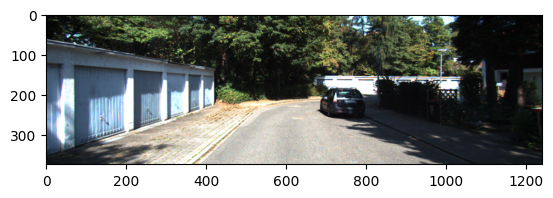

Car 0.0 0 -1.78 684.91 179.41 805.90 262.67 1.51 1.58 3.60 2.69 1.69 15.33 -1.60 5.08


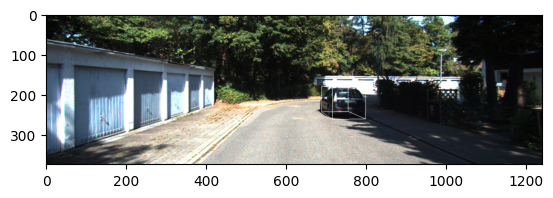

Car 0.00 0 -1.77 685.05 181.43 804.68 258.21 1.40 1.61 4.37 2.69 1.60 15.58 -1.61


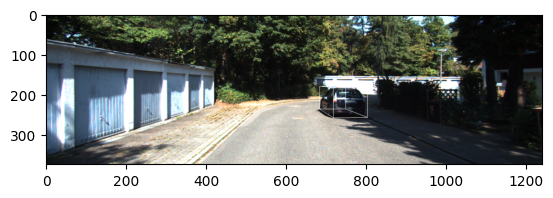

In [10]:
import cv2
from utilities.datasets.kitti.kitti_utils import Calibration, Object3d
from utilities.datasets.utils import draw_projected_box3d
import matplotlib.pyplot as plt

#173 weird


file_path = '/Users/strom/Desktop/monodle/outputs/data/000020.txt'  # Replace with the actual path to your .txt file

image_path = "/Users/strom/Desktop/monodle/data/KITTI/object/training/image_2/000020.png"
path = "/Users/strom/Desktop/monodle/data/KITTI/object/training/calib/000020.txt"
gt_path = "/Users/strom/Desktop/monodle/data/KITTI/object/training/label_2/000020.txt"

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

image2 = image3 = image

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace and newline characters
        # Process each line here
        print(line)
        test_obj = Object3d(line)
        calib_3D = Calibration(path)
        _ , boxes_corner = calib_3D.corners3d_to_img_boxes(np.resize(test_obj.generate_corners3d(),(1,8,3)))
        boxes = np.resize(boxes_corner,(8,2))[::-1]
        image2 = draw_projected_box3d(image, boxes, color=(255, 255, 255), thickness=1)

plt.imshow(image2)
plt.show()
        

image = plt.imread(image_path)

with open(gt_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace and newline characters
        # Process each line here
        print(line)
        test_obj = Object3d(line)
        calib_3D = Calibration(path)
        _ , boxes_corner = calib_3D.corners3d_to_img_boxes(np.resize(test_obj.generate_corners3d(),(1,8,3)))
        boxes = np.resize(boxes_corner,(8,2))[::-1]
        image3 = draw_projected_box3d(image, boxes, color=(255, 255, 255), thickness=1)

plt.imshow(image3)
plt.show()

In [9]:
int(torch.zeros(1))

0

In [ ]:
x = torch.rand(16,50)
x.view(16, 50, 1).float()

tensor([[[0.2816],
         [0.6847],
         [0.5377],
         [0.5233],
         [0.8115],
         [0.0858],
         [0.5261],
         [0.1413],
         [0.1686],
         [0.6929],
         [0.5706],
         [0.2725],
         [0.9066],
         [0.0961],
         [0.4513],
         [0.9548],
         [0.4237],
         [0.0824],
         [0.3262],
         [0.7110],
         [0.9740],
         [0.3430],
         [0.5891],
         [0.7747],
         [0.8342],
         [0.0862],
         [0.2736],
         [0.5093],
         [0.7120],
         [0.0830],
         [0.1414],
         [0.5851],
         [0.9426],
         [0.6939],
         [0.9394],
         [0.1747],
         [0.7419],
         [0.7269],
         [0.3455],
         [0.2738],
         [0.4728],
         [0.9059],
         [0.9990],
         [0.0026],
         [0.3083],
         [0.2340],
         [0.1229],
         [0.0632],
         [0.6013],
         [0.1273]],

        [[0.4139],
         [0.0232],
         [

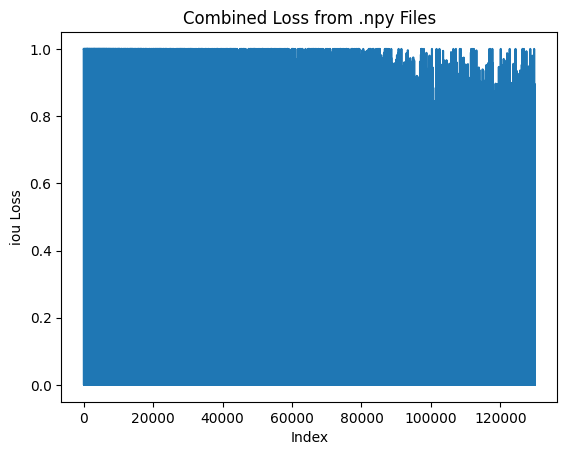

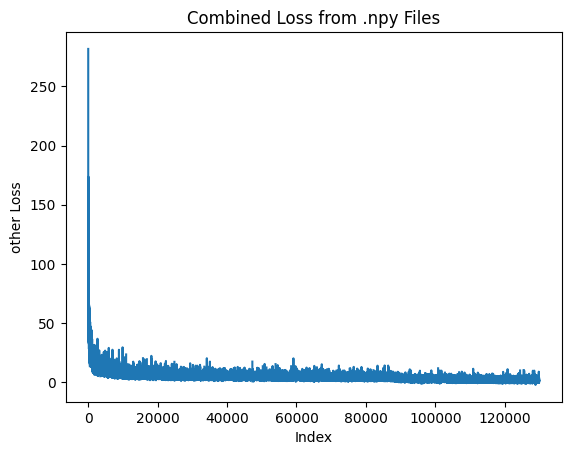

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of .npy files
num_files = 140

# Create an empty list to store the data from each .npy file
data_list = []
data_list2 = []

# Iterate over the range of numbers and load each .npy file
for i in range(num_files):
    file_path = f'/Users/strom/Desktop/monodle/loss_info/{i}iouloss.npy'
    data = np.load(file_path)
    data_list.append(data)

    file_path2 = f'/Users/strom/Desktop/monodle/loss_info/{i}otherloss.npy'
    data2 = np.load(file_path2)
    data_list2.append(data2)

# Concatenate the data from all .npy files along the desired axis
combined_data = np.concatenate(data_list, axis=0)
combined_data2 = np.concatenate(data_list2, axis=0)

# Plot the combined data
plt.plot(combined_data)
plt.xlabel('Index')
plt.ylabel('iou Loss')
plt.title('Combined Loss from .npy Files')
plt.show()

# Plot the combined data
plt.plot(combined_data2)
plt.xlabel('Index')
plt.ylabel('other Loss')
plt.title('Combined Loss from .npy Files')
plt.show()

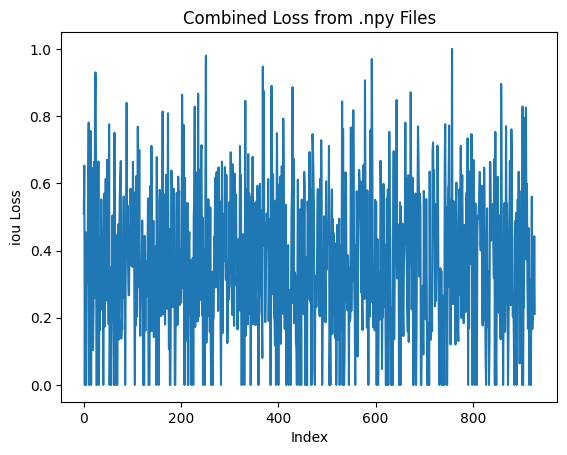

0.3604020395733673


In [20]:
data3 = np.load('/Users/strom/Desktop/monodle/loss_info/139iouloss.npy')
plt.plot(data3)
plt.xlabel('Index')
plt.ylabel('iou Loss')
plt.title('Combined Loss from .npy Files')
plt.show()

print(data3.mean())

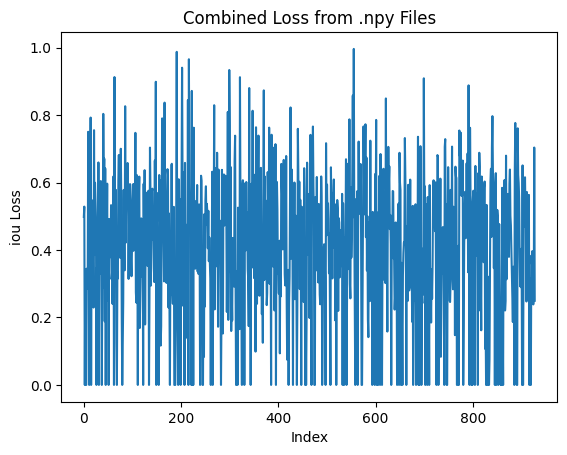

0.4043897253798385


In [19]:
data3 = np.load('/Users/strom/Desktop/monodle/loss_info/100iouloss.npy')
plt.plot(data3)
plt.xlabel('Index')
plt.ylabel('iou Loss')
plt.title('Combined Loss from .npy Files')
plt.show()

print(data3.mean())

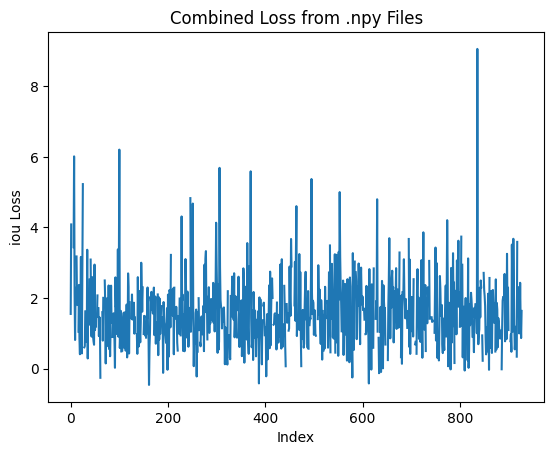

nan


In [22]:
data3 = np.load('/Users/strom/Desktop/monodle/loss_info/139otherloss.npy')
plt.plot(data3)
plt.xlabel('Index')
plt.ylabel('iou Loss')
plt.title('Combined Loss from .npy Files')
plt.show()

print(data3.mean())